In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit

# Solve as two dimensional

In [4]:
# x(t-tau), x(t), res
def get_prop(x_s, force, dt):
    N_x = len(x_s)
    R = np.zeros(( N_x,N_x, N_x))
    
    F = force(x_s)
    lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
    ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i

    R[:,0,0] = -lp
    R[:,-1,-1] = -ln
    R[:,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
    R[:,np.arange(0,N_x-1),np.arange(1,N_x)] = ln[:,None]
    R[:,np.arange(1,N_x),np.arange(0,N_x-1)] = lp[:,None]
    prop = expm(R*dt, )
    return prop

def get_prop_abs(x_s, force, dt, N_border):
    R_abs = np.zeros(( N_x,N_x, N_x))
    
    F = force(x_s)
    lp = D / dx**2 * np.exp((F*dx/D)/2)  # r_i->i+1
    ln = D / dx**2 * np.exp(-(F*dx/D)/2)  # r_i+1->i
    
    R_abs[:,0,0] = -lp
    R_abs[:,np.arange(1,N_border+1),np.arange(1,N_border+1)] = -(lp[:,None]+ln[:,None]) # -(r_i->i+1 + r_i->i-1) ????
    R_abs[:,np.arange(0,N_border),np.arange(1,N_border+1)] = ln[:,None]
    R_abs[:,np.arange(1,N_border),np.arange(0,N_border-1)] = lp[:,None]
    prop_abs = expm(R_abs*dt, )
    return prop_abs


def get_hists(N_t, N_x, ntau, i_zero, prop, thresh =  0.00001):

    def filter_prob(p):
        if p > thresh:
            return 1.
        return p/thresh
    filter_prob = np.vectorize(filter_prob)

    states = np.full((1,ntau+1),i_zero,dtype=int)
    probs = np.array([1.])
    total_prob = [1]
    unaltered_props = [1]

    hists = np.empty((N_t,N_x))

    for i in tqdm(np.arange(N_t)):
        a_s = np.swapaxes(prop,1,2)[states[:,0],states[:,-1],:]

        total_probs = a_s*probs[:,None]
        unaltered_props.append(np.sum(total_probs))
        #i_s = np.where(total_probs > 0.0000005)
        #new_probs = total_probs[i_s]
        i_s = np.where(total_probs > thresh*np.random.rand(*total_probs.shape))
        #print(total_probs[i_s])
        new_probs = total_probs[i_s]/filter_prob(total_probs[i_s])
        new_states = np.repeat(states[:,None,:],N_x, axis = 1,)[i_s]
        new_states[:,:-1] = new_states[:,1:]
        new_states[:,-1]  = i_s[1]


        uni, indxs = np.unique(new_states, axis=0, return_inverse=True)
        states = uni
        new_probs = np.stack([np.sum(new_probs[indxs == i]) for i in range(len(uni))])
        total_prob.append(np.sum(new_probs))
        probs = new_probs/np.sum(new_probs)

        hists[i] = [np.sum(probs[states[:,-1] == i]) for i in range(N_x)] 
    print('Total number of final states:', states.shape)
    return hists, unaltered_props, total_prob

def simulate_traj(N_p, N_loop, N_t, ntau, s, dt, border, force):
    pos = np.empty((N_loop,N_p,N_t))
    vel = s*np.random.randn(N_loop,N_p,N_t)*1/np.sqrt(dt)

    pos[:,:,:ntau+1] = -border
    vel[:,:,:ntau+1] = 0

    for i in tqdm(range(ntau+1,N_t)):
        pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
        vel[:,:,i] += force(pos[:,:,i-ntau])
    return pos


def get_rate(hists, dt,total_props=None):
    if total_props is None:
        sur_l = np.sum(hists[:,x_s <= 0],axis = 1)/np.sum(hists[0])
        sur_r = np.sum(hists[:,x_s > 0],axis = 1)/np.sum(hists[0])
    else:
        sur_l = np.sum(hists[:,x_s <= 0],axis = 1)/np.sum(hists[0]) * np.cumprod(total_props[1:])
        sur_r = np.sum(hists[:,x_s > 0],axis = 1)/np.sum(hists[0]) * np.cumprod(total_props[1:])
    rate = -np.diff(sur_l)/(sur_l[:-1]-sur_r[:-1])/dt
    return sur_l, rate

## One example

In [ ]:
k = 3
tau = 0.2
D = 1e-6
s = np.sqrt(2*D)
N_t = 300
dt = tau/4 if tau > 0 else 5e-2
dx = 4e-4 #1e-4


ntau = round(tau/dt)
ts = np.arange(0,N_t)*dt
ts_r = ts[1:]

sb = 0.005
# include zero as x point
# x_s = np.arange(-sb,sb+1e-5,dx)
# bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)

# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)

N_border = np.argmin(x_s**2) + 1 #(first after border) -> partices are going there nothing comes back

N_t = len(ts)
N_x = len(x_s)

# def force(x,*args):
#     return -k*x

# def force(x,*args):
#     return -k*x**3*1e6

border = 0.0014
def cusp_force(x):
    if x < 0:
        return -k*(x+border)
    else:
        return -k*(x-border)
force = np.vectorize(cusp_force)

# v_min = -1e-6
# border = 0.0018
# def force(x):
#     a = -v_min/border**4
#     b = -2*v_min/border**2
#     return -4*a*x**3+2*b*x

i_zero = np.argmin((x_s+border)**2)

In [14]:
prop = get_prop(x_s, force,dt)
prop_abs = get_prop_abs(x_s, force,dt,N_border)

hists, unaltered_props, total_prob = get_hists(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop)
hists_abs, unaltered_props_abs, total_prob_abs = get_hists(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop_abs)

  0%|          | 0/300 [00:00<?, ?it/s]

Total number of final states: (8527, 5)


  0%|          | 0/300 [00:00<?, ?it/s]

Total number of final states: (5022, 5)


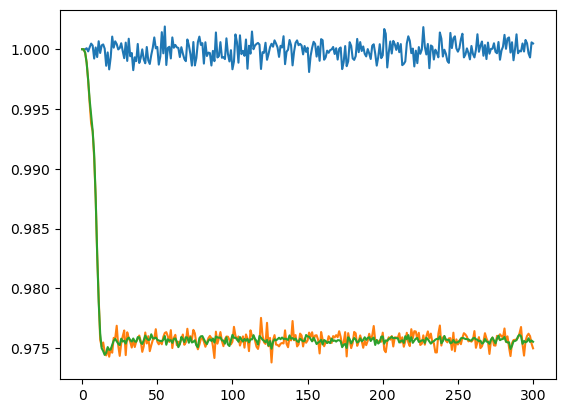

In [15]:
plt.plot(total_prob)
plt.plot(total_prob_abs)
plt.plot(unaltered_props_abs)

In [16]:
np.prod(total_prob), np.prod(total_prob_abs), np.prod(unaltered_props_abs)

(0.9743774903316598, 0.000743827778424432, 0.0007396942243192136)

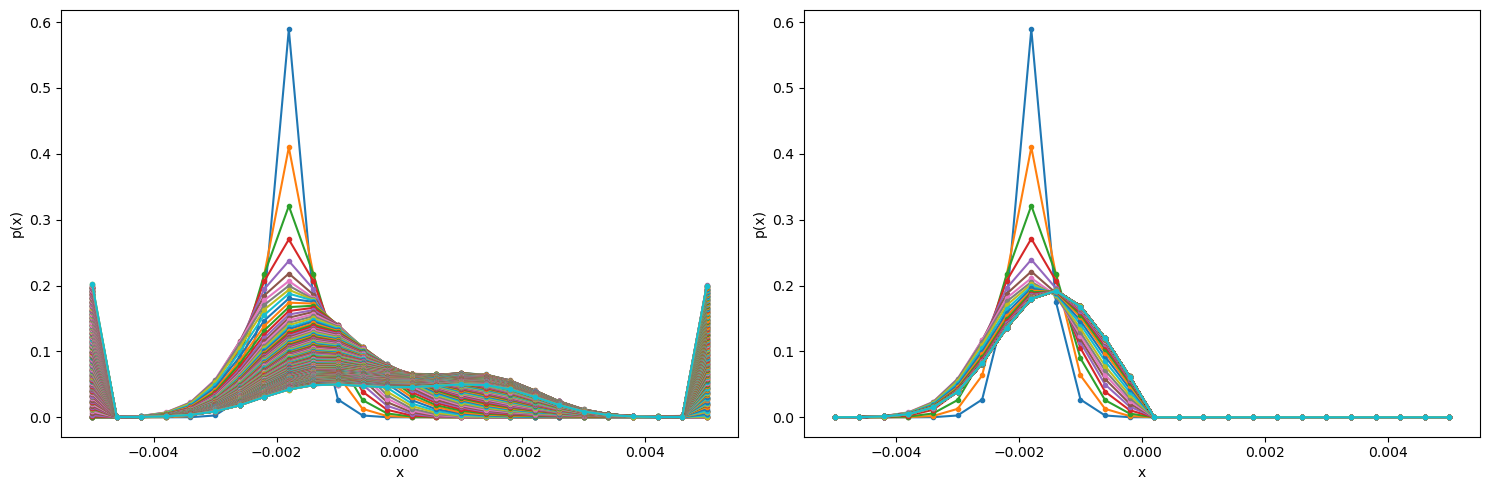

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
for hist in hists:
    plt.plot(x_s,hist,'.-')
plt.xlabel('x')
plt.ylabel('p(x)')
    
plt.subplot(122)
for hist,p in zip(hists_abs,np.cumprod(unaltered_props_abs)[1:]):
    plt.plot(x_s,hist,'.-')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.tight_layout()


In [19]:
f = 3
N_p = 60_000
ts_sim = np.arange(0,(N_t+ntau+2)*f)*dt/f-tau-dt

pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=border, force=force)
pos_abs = pos.copy()
for i in range(ntau+1, pos.shape[-1]):
    pos_abs[pos_abs[:,:,i] > 0,i:] = np.nan
    
all_pos = pos[0]
sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))]
    
all_pos_abs = pos_abs[0]
sim_hists_abs = [np.histogram(all_pos_abs[:,j], bins = bins)[0] for j in tqdm(range(all_pos_abs.shape[-1]))]

  0%|          | 0/905 [00:00<?, ?it/s]

/tmp/ipykernel_7128/3660105735.py:47: RuntimeWarning: overflow encountered in power
  return -4*a*x**3+2*b*x
/tmp/ipykernel_7128/2941606640.py:9: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
/tmp/ipykernel_7128/3660105735.py:47: RuntimeWarning: invalid value encountered in add
  return -4*a*x**3+2*b*x


  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/918 [00:00<?, ?it/s]

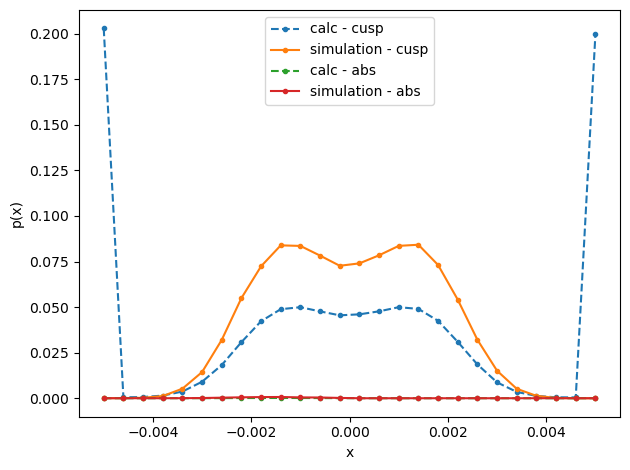

In [20]:
idx = N_t-1
plt.plot(x_s,hists[idx],'.--', label='calc - cusp')
plt.plot(x_s,sim_hists[(ntau+idx+2)*f]/N_p,'.-', label = 'simulation - cusp')

plt.plot(x_s,np.prod(unaltered_props_abs)*hists_abs[idx],'.--', label='calc - abs')
plt.plot(x_s,sim_hists_abs[(ntau+idx+2)*f]/N_p,'.-', label = 'simulation - abs')

plt.xlabel('x')
plt.ylabel('p(x)')

#plt.vlines((x_s[i_zero], 0), *plt.ylim(), color=['r','b'])
plt.legend()
plt.tight_layout()

/tmp/ipykernel_7128/1257374645.py:7: RuntimeWarning: divide by zero encountered in divide
  rate_sim = -np.diff(sur_sim)/(2*sur_sim[:-1]-1)/(dt/f)


(0.0, 1.0)

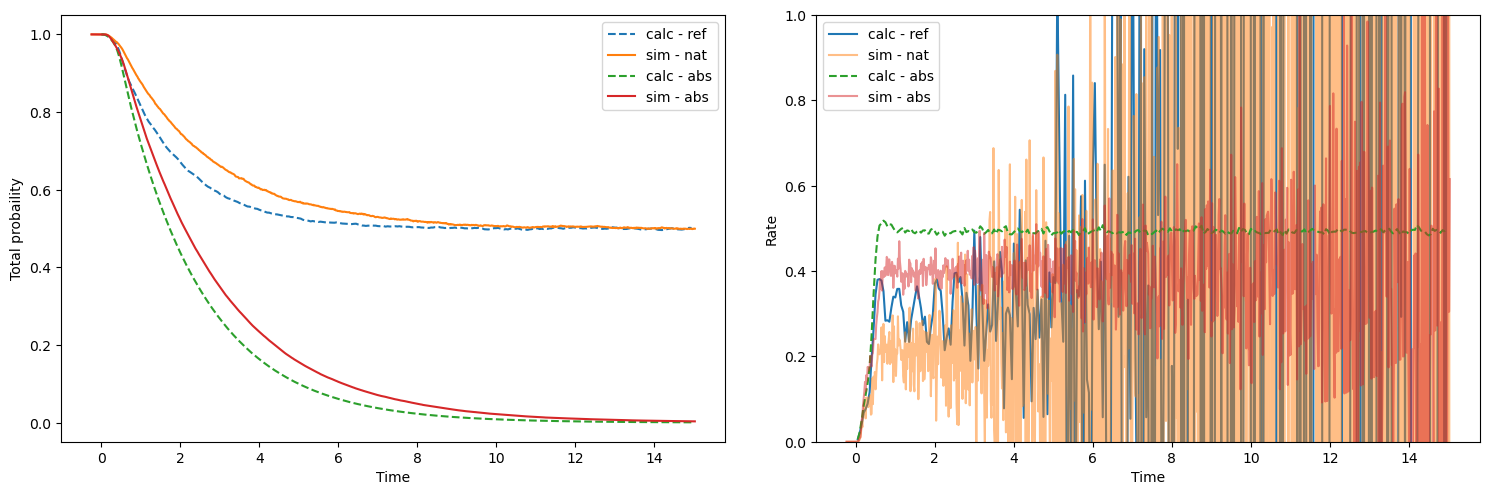

In [22]:
sur = 1-np.sum(hists[:,x_s > 0],axis = 1)
sur_sim = 1-np.sum(pos > 0, axis = (0,1))/N_p
s_abs = np.cumprod(unaltered_props_abs)[1:]
s_abs_sim = (np.sum(~np.isnan(pos_abs), axis=1)/N_p)[0]

rate = -np.diff(sur)/(2*sur[:-1]-1)/dt
rate_sim = -np.diff(sur_sim)/(2*sur_sim[:-1]-1)/(dt/f)
r_abs = -np.diff(np.log(s_abs))/dt
r_abs_sim = -np.diff(np.log(s_abs_sim))/(dt/f)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(ts,sur,'--', label='calc - ref')
plt.plot(ts_sim,sur_sim, label='sim - nat')
plt.plot(ts, s_abs,'--', label='calc - abs')
plt.plot(ts_sim,s_abs_sim, label = 'sim - abs')
plt.xlabel('Time')
plt.ylabel('Total probaility')
plt.legend()


plt.subplot(122)
plt.plot(ts[1:],rate, label='calc - ref')
plt.plot(ts_sim[1:],rate_sim,alpha = 0.5,label='sim - nat')
plt.plot(ts[1:],r_abs,'--', label='calc - abs')
plt.plot(ts_sim[1:],r_abs_sim, alpha = 0.5,label = 'sim - abs')
plt.xlabel('Time')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.ylim(0,1)

In [23]:
tau*10

2.0

In [24]:
eq_t = 10*tau
m_r = np.nanmean(rate[ts[1:] > eq_t])
m_r_sim = rate_sim[ts_sim[1:] > eq_t].mean()
m_r_abs = r_abs[ts[1:] > eq_t].mean()
m_r_abs_sim = r_abs_sim[ts_sim[1:] > eq_t].mean()

print('calc cusp: \t',m_r)
print('sim cusp: \t', m_r_sim)
print('calc abs: \t',m_r_abs)
print('sim abs: \t', m_r_abs_sim)

calc cusp: 	 -2.9018495621335694
sim cusp: 	 -inf
calc abs: 	 0.49285451559893756
sim abs: 	 0.390179128968774


In [25]:
print(m_r/m_r_sim)

0.0


In [26]:
print(m_r_abs/m_r_abs_sim)

1.2631493563008611


## rate of tau

In [35]:
k = 3
D = 1e-6
s = np.sqrt(2*D)
N_t = 75
dx = 4e-4

sb = 0.005

f = 3
N_p = 60_000


x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_border = np.argmin(x_s**2) + 1 #(first after border) -> partices are going there nothing comes back
N_x = len(x_s)

v_min = -1e-6
border = 0.003 #0.0018
def force(x):
    a = -v_min/border**4
    b = -2*v_min/border**2
    return -4*a*x**3+2*b*x
i_zero = np.argmin((x_s+border)**2)

# border = 0.002 #0.0014
# def cusp_force(x):
#     if x < 0:
#         return -k*(x+border)
#     else:
#         return -k*(x-border)
# force = np.vectorize(cusp_force)
# i_zero = np.argmin((x_s+border)**2)

all_res = []
all_res_abs = []

all_sim_res = []
all_sim_res_abs = []
taus = np.arange(0,0.61,0.1)

for tau in tqdm(taus):
    dt = tau/4 if tau > 0 else taus[1]/4
    ntau = round(tau/dt)
    ts = np.arange(0,N_t)*dt
    prop = get_prop(x_s, force,dt)
    prop_abs = get_prop_abs(x_s, force,dt,N_border)

    all_res.append([ts,*get_hists(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop)])
    all_res_abs.append([ts,*get_hists(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop_abs)])





    ts_sim = np.arange(0,(N_t+ntau+2)*f)*dt/f-tau-dt
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=border, force=force)
    pos_abs = pos.copy()
    for i in range(ntau+1, pos.shape[-1]):
        pos_abs[pos_abs[:,:,i] > 0,i:] = np.nan

    all_pos = pos[0]
    sim_hists = np.stack([np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))])

    all_pos_abs = pos_abs[0]
    sim_hists_abs = np.stack([np.histogram(all_pos_abs[:,j], bins = bins)[0] for j in tqdm(range(all_pos_abs.shape[-1]))])
    
    all_sim_res.append([ts_sim, sim_hists])
    all_sim_res_abs.append([ts_sim, sim_hists_abs])
    
all_all_res = [all_res, all_res_abs, all_sim_res,all_sim_res_abs]
with open('nummeric_results/dv_res_high_border.pkl', 'wb') as file:
    pickle.dump({
        'k':k,
        'D':D,
        'N_t':N_t,
        'border':border,
        'dx':dx,
        'sb':sb,
        'f':f,
        'N_p':N_p,        
        'taus':taus,
        'all_all_res':all_all_res},file)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (25, 1)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (13, 1)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (3419, 5)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (2729, 5)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (8180, 5)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (5714, 5)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (13635, 5)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (8764, 5)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (19658, 5)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (11948, 5)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (25235, 5)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (15096, 5)


  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (30900, 5)


  0%|          | 0/75 [00:00<?, ?it/s]

Total number of final states: (18210, 5)


  0%|          | 0/230 [00:00<?, ?it/s]

/tmp/ipykernel_8157/1030711174.py:23: RuntimeWarning: overflow encountered in power
  return -4*a*x**3+2*b*x
/tmp/ipykernel_8157/2873439592.py:81: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt
/tmp/ipykernel_8157/1030711174.py:23: RuntimeWarning: invalid value encountered in add
  return -4*a*x**3+2*b*x


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

In [64]:
pickle_obj =  pickle.load(open('nummeric_results/dv_res.pkl', 'rb') )
#pickle_obj =  pickle.load(open('nummeric_results/cusp_res.pkl', 'rb') )
#pickle_obj =  pickle.load(open('nummeric_results/cusp_res_high_border.pkl', 'rb') )
#pickle_obj =  pickle.load(open('nummeric_results/dv_res_high_border.pkl', 'rb') )
k = pickle_obj['k']
D = pickle_obj['D']
N_t = pickle_obj['N_t']
dx = pickle_obj['dx']
sb = pickle_obj['sb']
f = pickle_obj['f']
N_p = pickle_obj['N_p']
taus = pickle_obj['taus']
all_all_res = pickle_obj['all_all_res']

s = np.sqrt(2*D)
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_border = np.argmin(x_s**2) + 1 #(first after border) -> partices are going there nothing comes back
N_x = len(x_s)

/tmp/ipykernel_8157/2873439592.py:93: RuntimeWarning: divide by zero encountered in divide
  rate = -np.diff(sur_l)/(sur_l[:-1]-sur_r[:-1])/dt


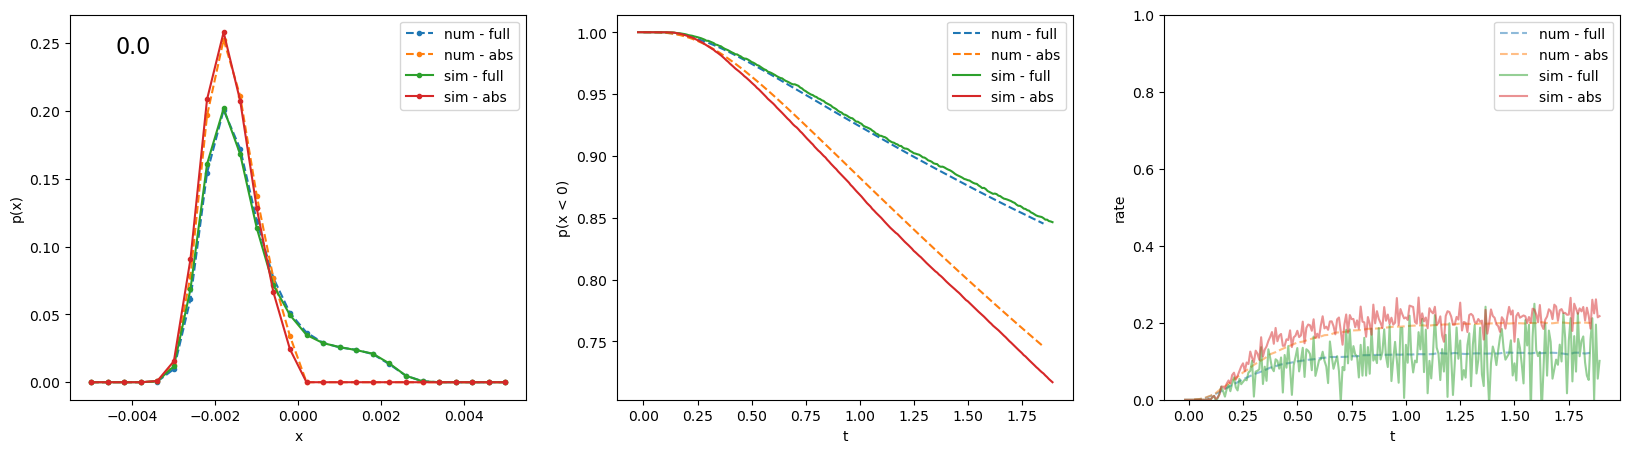

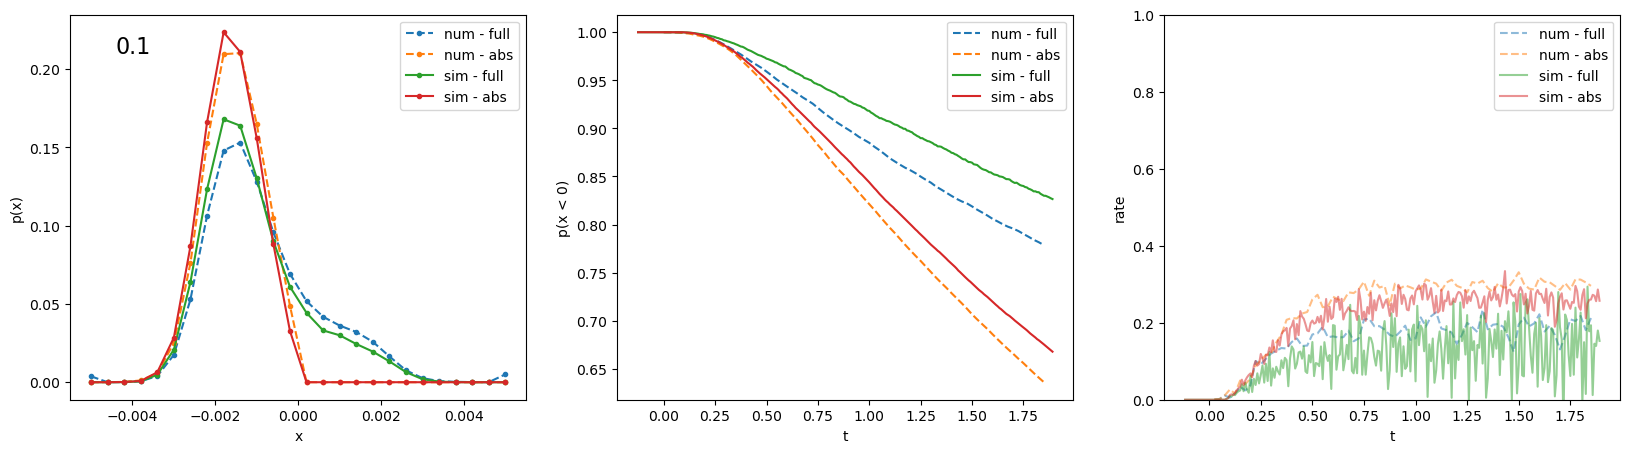

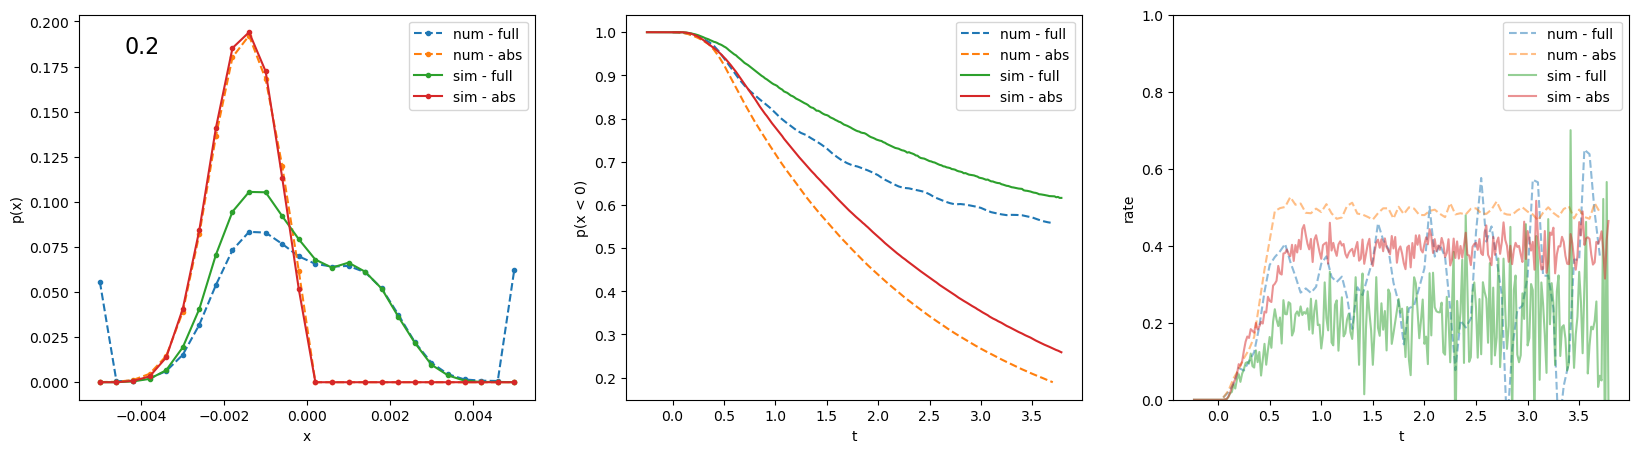

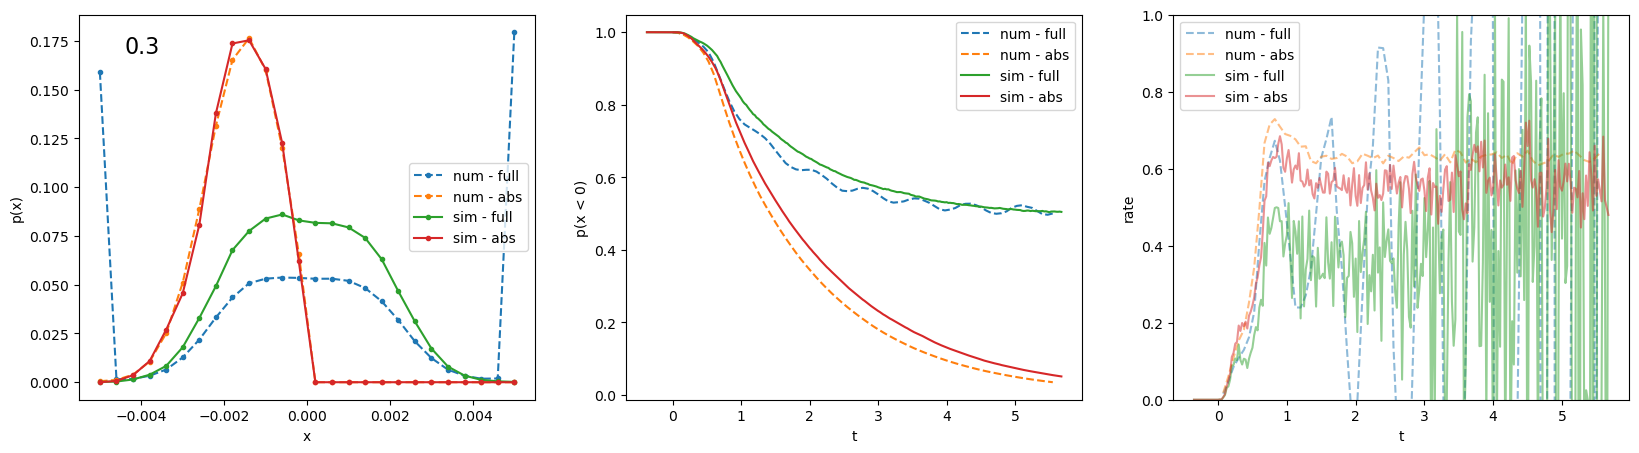

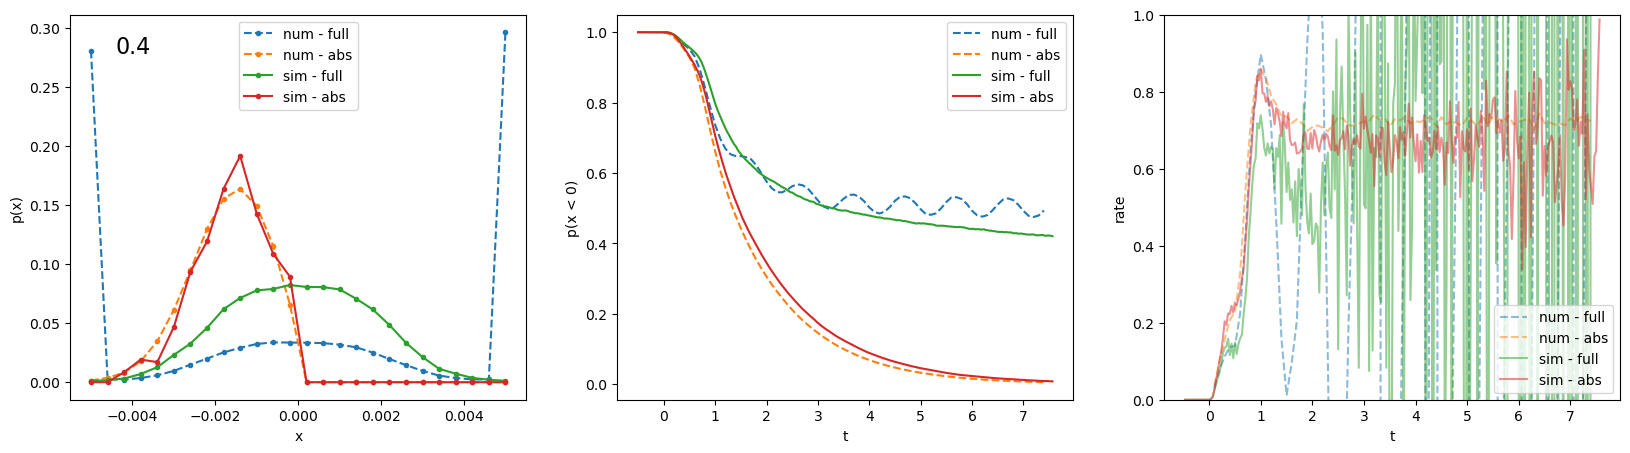

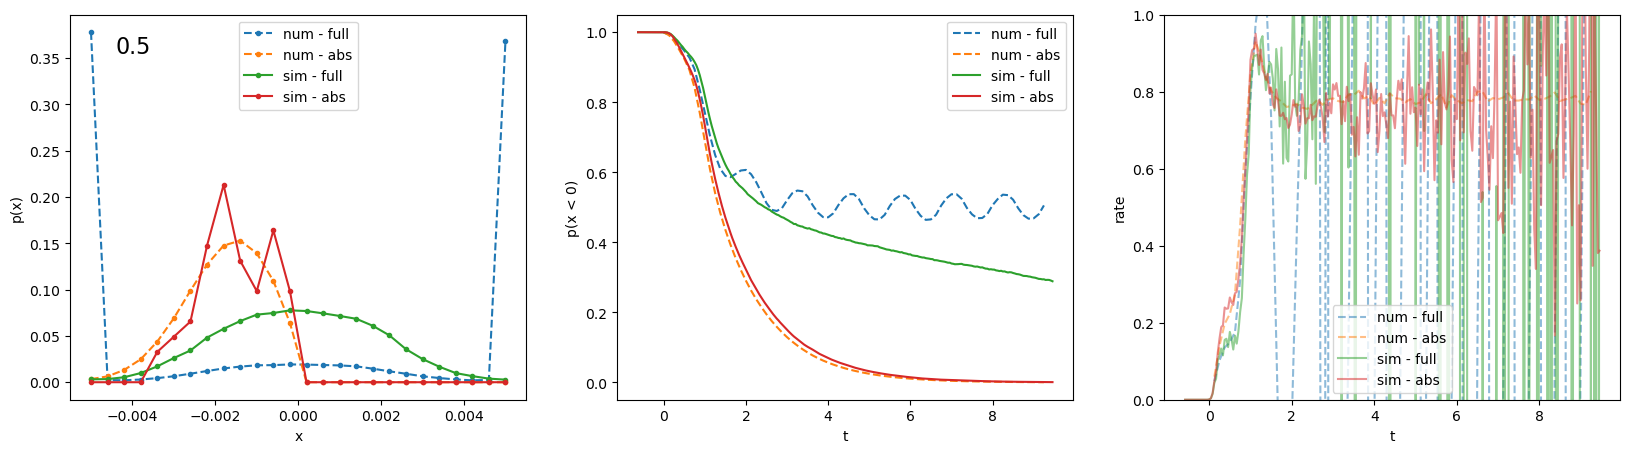

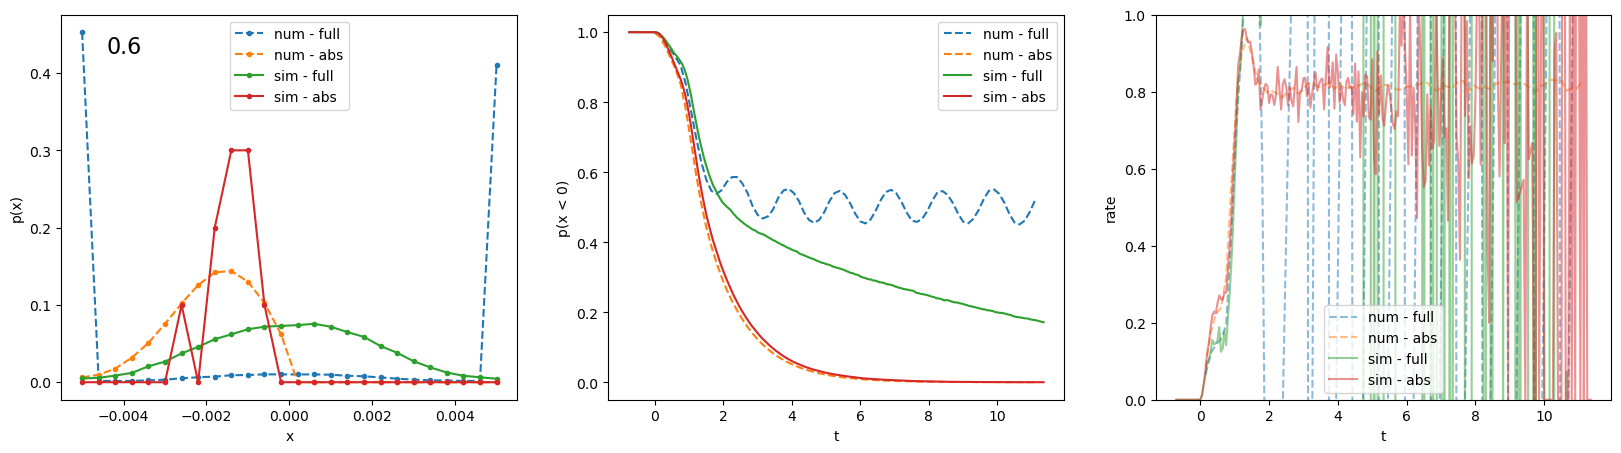

In [65]:
ls_s= ['--','--','-','-']
labels = ['num - full','num - abs', 'sim - full', 'sim - abs']
m_r = np.empty((len(taus), len(all_all_res)))

for tau_i,ltau in enumerate(taus):
    plt.figure(figsize=(20,5))
    for j,(all_r,ls, label) in enumerate(zip(all_all_res, ls_s, labels)):
        dt = all_r[tau_i][0][1]-all_r[tau_i][0][0]
        if len(all_r[0]) > 2:
            s,r = get_rate(np.stack(all_r[tau_i][1]), dt, total_props = all_r[tau_i][3])
        else:
            s,r = get_rate(np.stack(all_r[tau_i][1]), dt)


        plt.subplot(131)
        plt.plot(x_s,all_r[tau_i][1][-1]/np.sum(all_r[tau_i][1][-1]), ls = ls, marker = '.', label = label)
        plt.legend()
        
        plt.subplot(132)
        plt.plot(all_r[tau_i][0],s, ls=ls, label = label)
        plt.legend()
        
        plt.subplot(133)
        plt.plot(all_r[tau_i][0][1:],r,ls=ls, alpha = 0.5, label = label)
        plt.ylim(0,1)
        plt.legend()
        
        m_r[tau_i, j] = r[all_r[tau_i][0][1:] > taus[tau_i]*10].mean()
        
    ax = plt.subplot(131)
    plt.text(0.1, 0.9, round(ltau,1),  transform = ax.transAxes, fontsize = 16)
    plt.xlabel('x')
    plt.ylabel('p(x)')
    
    plt.subplot(132)
    plt.xlabel('t')
    plt.ylabel('p(x < 0)')
    
    plt.subplot(133)
    plt.xlabel('t')
    plt.ylabel('rate')

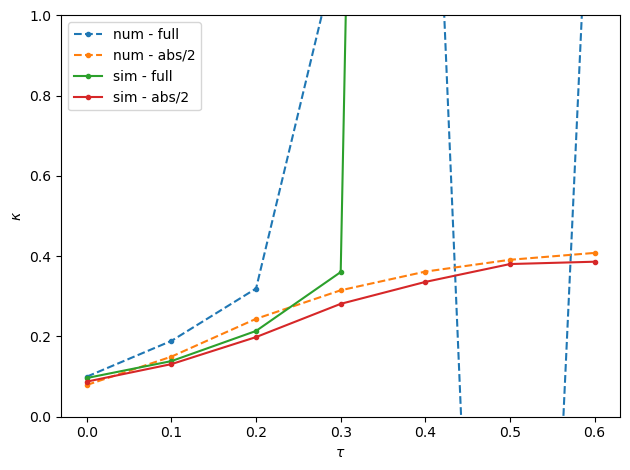

In [66]:
for i, (ls, label) in enumerate(zip(ls_s, labels)):
    if i%2:
        plt.plot(taus[:],m_r[:,i]/2, ls=ls, marker='.', label=label+"/2")
    else:
        plt.plot(taus[:],m_r[:,i], ls=ls, marker='.', label=label)
plt.ylim(0,1)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\kappa$')
plt.legend()
plt.tight_layout()
#plt.savefig('Graphic_Results/kappa_cusp_2dalgo.pdf')

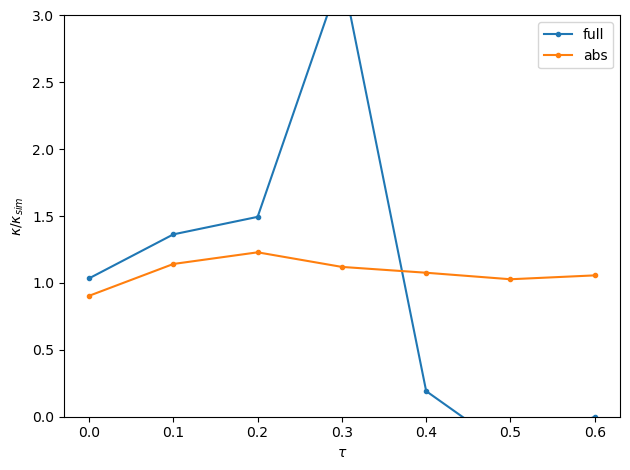

In [67]:
plt.plot(taus[:],m_r[:,0]/m_r[:,2] , marker='.', label='full')
plt.plot(taus[:],m_r[:,1]/m_r[:,3] , marker='.', c = 'C1', label='abs')
plt.ylim(0,3)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\kappa/\kappa_{sim}$')
plt.legend()
plt.tight_layout()
#plt.savefig('Graphic_Results/kappa_cusp_2dalgo_ratios.pdf')